## Get data from https://www.mykhel.com/

In [1]:
# Import libraries
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pprint
import re

#### Main Body
1. Get url
2. Create BeautifulSoup object

In [2]:
# season = "6"
# base_url = "https://www.mykhel.com/kabaddi/pro-kabaddi-stats/?season="
# mid = season
# xtn_url = "#teams#stats-13"
# url = base_url + mid + xtn_url

# print(url)   

In [3]:
# url = "https://www.mykhel.com/kabaddi/pro-kabaddi-stats/#teams#stats-96"

def create_object(season):
#     url = "https://www.mykhel.com/kabaddi/pro-kabaddi-stats/"
    base_url = "https://www.mykhel.com/kabaddi/pro-kabaddi-stats/?season="
    mid = str(season)
    xtn_url = "#teams#stats-13"
    url = base_url + mid + xtn_url

    
    # prepare headers
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'}

    # Get data
    req_tot = requests.get(url,headers=headers)

    # create a bs4 object
    # To avoid warnings, provide "html5lib" explicitly
    soup2 = BeautifulSoup(req_tot.text, "html5lib")
    return soup2

#### Create list of all tables

In [4]:
def table_details(soup):
    soup2 = soup
    all_tables = soup2.find_all("div",{"class":"pk-stats__table"})

    table_list=[]
    
    for tables in all_tables:
        table_list.append([tables.attrs["id"],tables.find("h2").text])
       
    # Split player and team table
    table_player = [item for item in table_list if item[1].startswith("Player")]
    table_team = [item for item in table_list if item[1].startswith("Team")]
    
    return (soup2,table_player,table_team)

#### Create function to team player table details

In [5]:
def get_team_idtable(soup,idpass,idname,season):
    soup2 = soup
    team_stat = soup2.find_all(id=idpass)

    rec_data=[]
    
    # Fetch team name, games, points   
    for team_rec in team_stat:
        team = team_rec.find_all("tr")
        for item in team:
            rec = str(item.find_all("strong"))
            rec = rec.replace("<strong>"," ").replace("</strong>"," ").replace("["," ").replace("]"," ")
            rec_data.append(rec.split(","))


    team_data = pd.DataFrame(rec_data[1:],columns=["team","played","points"])
    team_data["table"]=idname
    team_data["season"]=season
    
    return team_data

#### Call function and create dataframe with all team details

In [6]:
seasons_list = ["1","2","3","4","5","6","7"]

team_all = pd.DataFrame(columns=["team","played","points","table","season"]) 

for season in seasons_list:
    soup = create_object(season)
    soup2,table_player,table_team = table_details(soup)
       

    for ptable in table_team:
        team_temp = pd.DataFrame(columns=["team","played","points","table","season"]) 
        team_temp = get_team_idtable(soup2,ptable[0],ptable[1],season)

        team_all = team_all.append(team_temp)
    
        # Clean team dataframe
        team_all.set_index("team",inplace=True)
        team_all.reset_index(inplace=True)

In [7]:
team_all.head()

,team,played,points,table,season
0,Telugu Titans,14,272,Team - Successful Raids,1
1,U Mumba,16,270,Team - Successful Raids,1
2,Jaipur Pink Panthers,16,270,Team - Successful Raids,1
3,Patna Pirates,16,253,Team - Successful Raids,1
4,Dabang Delhi K.C.,14,246,Team - Successful Raids,1


#### Create function to return player table details

In [8]:
def get_player_idtable(soup,idpass,idname,season):
    
    soup2 = soup
    
    team_stat = soup2.find_all(id=idpass)

    rec_data=[]
    
    # Fetch player name, games, points   
    for team_rec in team_stat:
        team = team_rec.find_all("tr")
        for item in team:
            rec = str(item.find_all("strong"))
            rec = rec.replace("<strong>"," ").replace("</strong>"," ").replace("["," ").replace("]"," ")
            rec_data.append(rec.split(","))

    team_data = pd.DataFrame(rec_data[1:],columns=["player","player_2","played","points"])
    team_data["table"]=idname
    team_data["season"]=season

    
    return team_data

#### Clean team dataframe ````player_all````

In [9]:
player_all = pd.DataFrame(columns=["player","player_2","played","points","table","season"]) 

for season in seasons_list:
    soup = create_object(season)
    soup2,table_player,table_team = table_details(soup)

    for ptable in table_player:
        player_temp = pd.DataFrame(columns=["player","player_2","played","points","table","season"]) 
        player_temp = get_player_idtable(soup2,ptable[0],ptable[1],season)

        player_all = player_all.append(player_temp)
    
    # Clean player dataframe
    player_all["player"] = player_all["player"].apply(lambda c:c.strip())
    player_all.drop("player_2",axis=1,inplace=True)
    player_all

C:\Users\rush2\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
player_all.head()

,played,player,points,season,table
0,16,Anup Kumar,123,1,Player - Successful Raids
1,14,Rahul Chaudhari,123,1,Player - Successful Raids
2,16,Maninder Singh,103,1,Player - Successful Raids
3,14,Surjeet Narwal,100,1,Player - Successful Raids
4,15,Ajay Thakur,99,1,Player - Successful Raids


## Data Analysis

#### Visualization on Team data

In [11]:
# Convert datatype
team_all["points"] = team_all["points"].astype(float)
team_all["played"] = team_all["played"].astype(float)
team_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 5 columns):
team      952 non-null object
played    952 non-null float64
points    952 non-null float64
table     952 non-null object
season    952 non-null object
dtypes: float64(2), object(3)
memory usage: 37.3+ KB


In [12]:
# cri = "Team - Successful Raids"

# temp_data = team_all.loc[team_all["table"]==cri]
# sns.barplot(y="team",x="points",data=temp_data)

# plt.title("Sample",color="B")


# # sns.set_color_codes("")
# plt.plot()

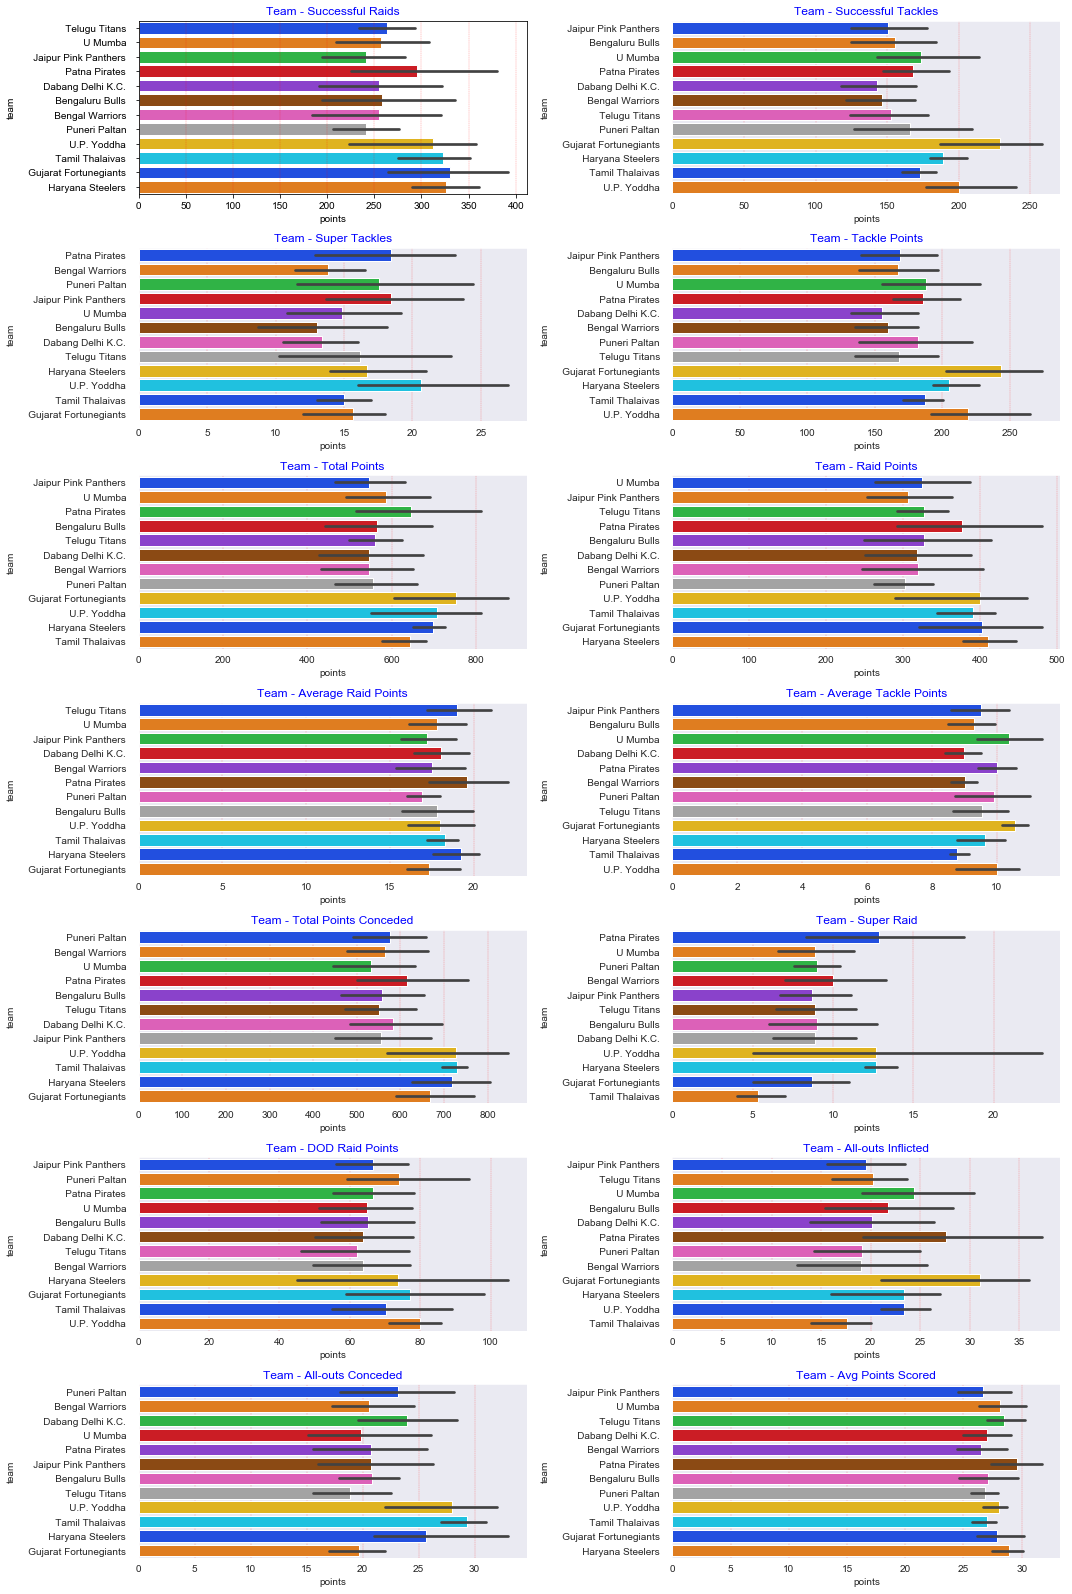

In [13]:
# Plot barplots
cri_list = team_all["table"].unique()

ln=len(cri_list)

# calculation for subplots
n=2
m=(ln//n)+1
ct=1

# Setting figure size
plt.figure(1,figsize=(15,25))

for cri in cri_list:
    plt.subplot(m,n,ct)
    sns.set_style("dark")
    plt.grid(color='r', linestyle='-.', linewidth=0.2)
    temp_data = team_all.loc[team_all["table"]==cri]
    sns.barplot(y="team",x="points",data=temp_data,palette="bright")
    plt.title(cri,color="b")
    ct+=1
    
# plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Visualization on Player data

In [14]:
# Convert datatype
player_all["points"] = player_all["points"].astype(float)
player_all["played"] = player_all["played"].astype(float)
player_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6915 entries, 0 to 127
Data columns (total 5 columns):
played    6915 non-null float64
player    6915 non-null object
points    6915 non-null float64
season    6915 non-null object
table     6915 non-null object
dtypes: float64(2), object(3)
memory usage: 324.1+ KB


In [15]:
cri_list = player_all["table"].unique()

cri = cri_list[0]
print(cri)
temp_data = player_all.loc[player_all["table"]==cri]
temp_data = temp_data.sort_values(by="points",ascending=False).head(10)
temp_data


Player - Successful Raids


,played,player,points,season,table
0,26.0,Pardeep Narwal,271.0,5,Player - Successful Raids
0,20.0,Naveen Kumar,213.0,7,Player - Successful Raids
0,24.0,Pawan Sehrawat,209.0,6,Player - Successful Raids
1,22.0,Rohit Kumar,192.0,5,Player - Successful Raids
1,19.0,Pardeep Narwal,190.0,7,Player - Successful Raids
2,19.0,Pawan Sehrawat,187.0,7,Player - Successful Raids
1,21.0,Pardeep Narwal,185.0,6,Player - Successful Raids
2,22.0,Ajay Thakur,182.0,5,Player - Successful Raids
2,22.0,Ajay Thakur,177.0,6,Player - Successful Raids
3,20.0,Maninder Singh,171.0,7,Player - Successful Raids


In [16]:
cri_list

array(['Player - Successful Raids', 'Player - Raid Points',
       'Player - Successful Tackles', 'Player - Super Tackles',
       'Player - Super 10s', 'Player - High 5s', 'Player - Total Points',
       'Player - Tackle Points', 'Player - Super Raids',
       'Player - DOD Raid Points', 'Player - Avg Raid Points',
       'Player - Avg Tackle Points'], dtype=object)

In [17]:
# Plot barplots
cri_list = player_all["table"].unique()

ln=len(cri_list)

# calculation for subplots
n=2
m=(ln//n)+1
ct=1

# Setting figure size
plt.figure(1,figsize=(80,150))

for cri in cri_list:
    plt.subplot(m,n,ct)
    sns.set_style("dark")
    plt.grid(color='r', linestyle='-.', linewidth=0.4)
    temp_data = player_all.loc[player_all["table"]==cri]
    #Just take top10
    temp_data = temp_data.sort_values(by="points",ascending=False).head(10)
    sns.barplot(y="player",x="points",data=temp_data,palette="bright")
    plt.yticks(fontsize=60)
    plt.xticks(fontsize=50)
    plt.title(cri,fontsize=80,color="b")
    ct+=1
    
# plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [18]:
team_list = team_all["team"].unique()
team_list

array(['   Telugu Titans  ', '   U Mumba  ', '   Jaipur Pink Panthers  ',
       '   Patna Pirates  ', '   Dabang Delhi K.C.  ',
       '   Bengaluru Bulls  ', '   Bengal Warriors  ',
       '   Puneri Paltan  ', '   U.P. Yoddha  ', '   Tamil Thalaivas  ',
       '   Gujarat Fortunegiants  ', '   Haryana Steelers  '],
      dtype=object)

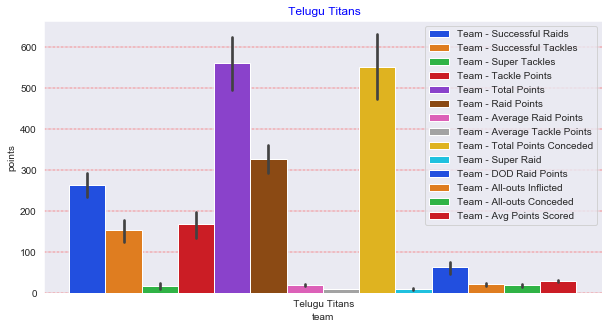

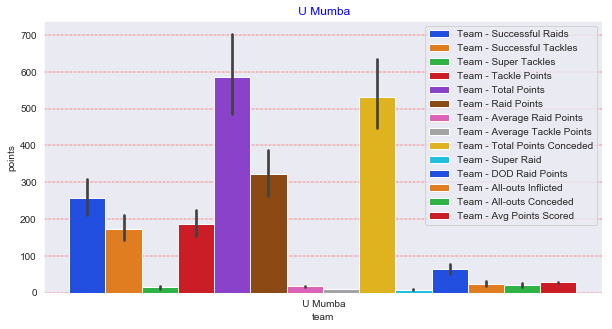

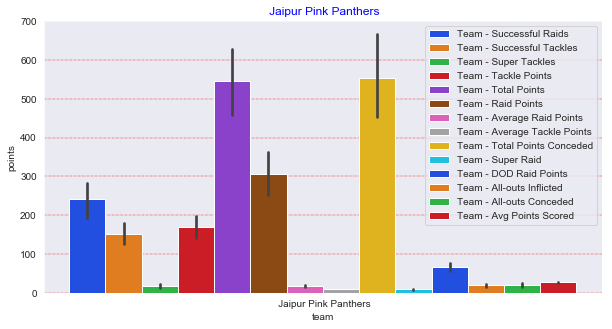

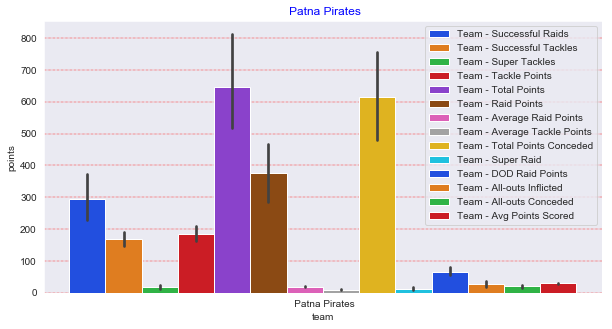

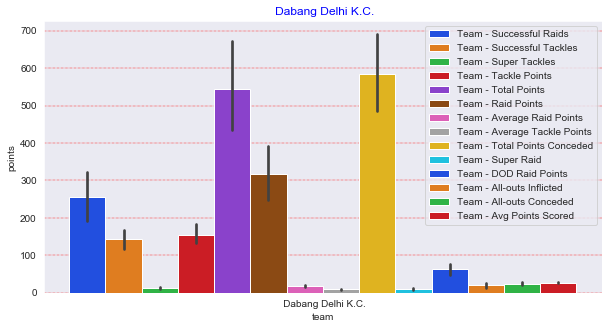

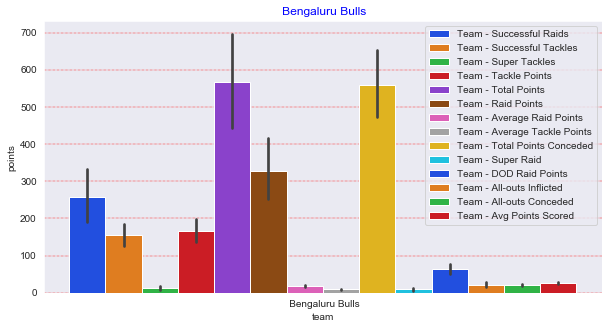

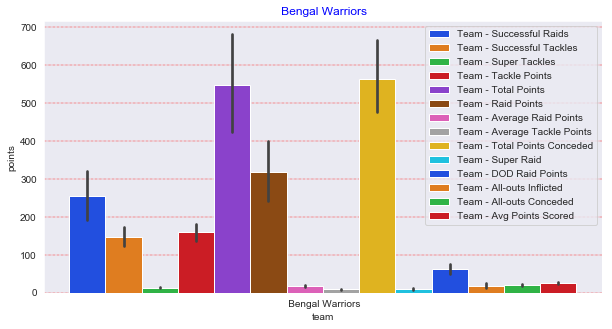

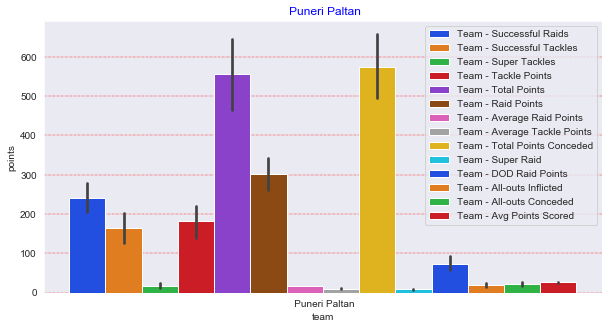

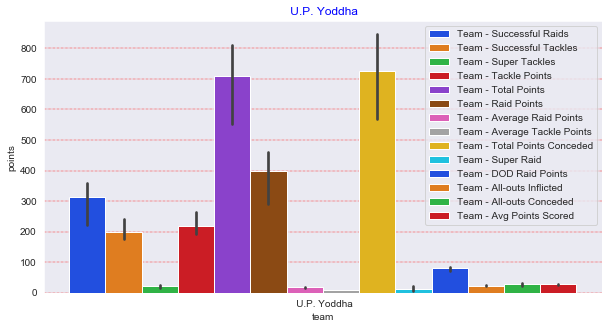

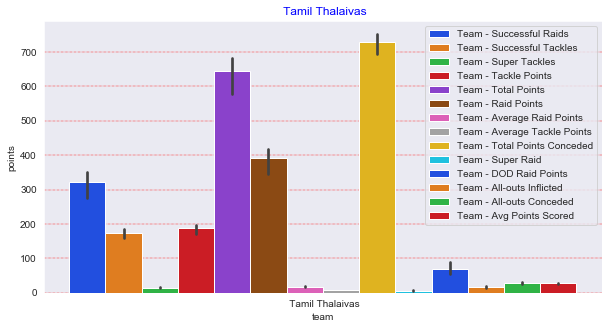

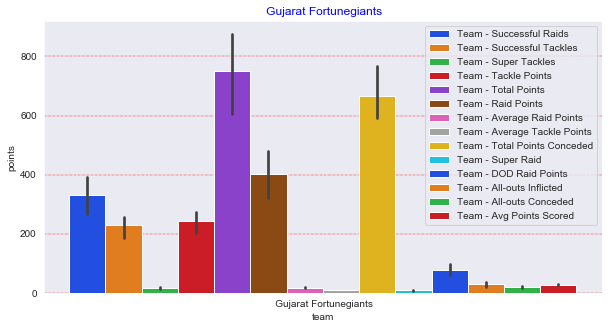

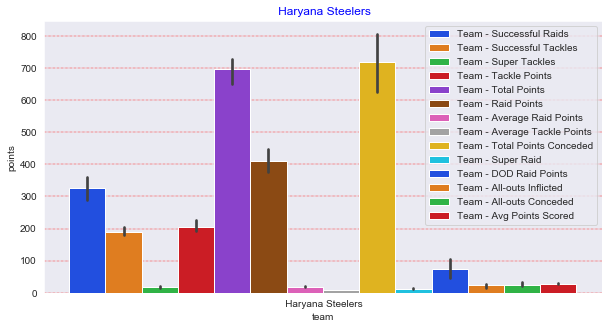

In [19]:
ln=len(team_list)

i=1
for team in team_list:
    plt.figure(i,figsize=(10,5))
    sns.set_style("dark")
    plt.grid(color='r', linestyle='-.', linewidth=0.4)
    data_team = team_all[team_all["team"]== team]
    sns.barplot(x="team",y="points",hue="table",data=data_team,palette="bright")
    plt.title(team,color="b")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.plot()
    i+=1

In [20]:
## Export raw data for analysis
# player_all.to_csv("./player_all.csv", index = False)
# team_all.to_csv("./team_all.csv", index = False)

## Analysis on Data

In [21]:
list_teamtbl = list(team_all["table"].unique())
list_teamtbl

['Team - Successful Raids',
 'Team - Successful Tackles',
 'Team - Super Tackles',
 'Team - Tackle Points',
 'Team - Total Points',
 'Team - Raid Points',
 'Team - Average Raid Points',
 'Team - Average Tackle Points',
 'Team - Total Points Conceded',
 'Team - Super Raid',
 'Team - DOD Raid Points',
 'Team - All-outs Inflicted',
 'Team - All-outs Conceded',
 'Team - Avg Points Scored']

In [22]:
team_c = team_all.copy()

In [23]:
team_c = team_c.set_index("team")
team_c.head()

,played,points,table,season
team,,,,
Telugu Titans,14.0,272.0,Team - Successful Raids,1
U Mumba,16.0,270.0,Team - Successful Raids,1
Jaipur Pink Panthers,16.0,270.0,Team - Successful Raids,1
Patna Pirates,16.0,253.0,Team - Successful Raids,1
Dabang Delhi K.C.,14.0,246.0,Team - Successful Raids,1


#### Merge team data for season 7

## Merge all team data for all seasons

In [24]:
all_season = list(team_c["season"].unique())

team_temp = pd.DataFrame(columns = ['Successful Raids_played', 'Successful Raids_points',
       'Successful Raids_table', 'Successful Raids_season',
       'Successful Tackles_played', 'Successful Tackles_points',
       'Successful Tackles_table', 'Successful Tackles_season',
       'Super Tackles_played', 'Super Tackles_points', 'Super Tackles_table',
       'Super Tackles_season', 'Tackle Points_played', 'Tackle Points_points',
       'Tackle Points_table', 'Tackle Points_season', 'Total Points_played',
       'Total Points_points', 'Total Points_table', 'Total Points_season',
       'Raid Points_played', 'Raid Points_points', 'Raid Points_table',
       'Raid Points_season', 'Average Raid Points_played',
       'Average Raid Points_points', 'Average Raid Points_table',
       'Average Raid Points_season', 'Average Tackle Points_played',
       'Average Tackle Points_points', 'Average Tackle Points_table',
       'Average Tackle Points_season', 'Total Points Conceded_played',
       'Total Points Conceded_points', 'Total Points Conceded_table',
       'Total Points Conceded_season', 'Super Raid_played',
       'Super Raid_points', 'Super Raid_table', 'Super Raid_season',
       'DOD Raid Points_played', 'DOD Raid Points_points',
       'DOD Raid Points_table', 'DOD Raid Points_season',
       'All-outs Inflicted_played', 'All-outs Inflicted_points',
       'All-outs Inflicted_table', 'All-outs Inflicted_season',
       'All-outs Conceded_played', 'All-outs Conceded_points',
       'All-outs Conceded_table', 'All-outs Conceded_season',
       'Avg Points Scored_played', 'Avg Points Scored_points',
       'Avg Points Scored_table', 'Avg Points Scored_season', 'season'])

team_point = team_temp.copy()

for season in all_season:
    
    season_cri = team_c["season"]==season

    team1 = team_c.loc[(team_c["table"]=='Team - Successful Raids') & (season_cri)]
    val1 = team1["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team1 = team1.add_prefix(prefix+"_")

    team2 = team_c.loc[(team_c["table"]=='Team - Successful Tackles') & (season_cri)]
    val1 = team2["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team2 = team2.add_prefix(prefix+"_")

    team3 = team_c.loc[(team_c["table"]=='Team - Super Tackles') & (season_cri)]
    val1 = team3["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team3 = team3.add_prefix(prefix+"_")

    team4 = team_c.loc[(team_c["table"]=='Team - Tackle Points') & (season_cri)]
    val1 = team4["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team4 = team4.add_prefix(prefix+"_")

    team5 = team_c.loc[(team_c["table"]=='Team - Total Points') & (season_cri)]
    val1 = team5["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team5 = team5.add_prefix(prefix+"_")

    team6 = team_c.loc[(team_c["table"]=='Team - Raid Points') & (season_cri)]
    val1 = team6["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team6 = team6.add_prefix(prefix+"_")

    team7 = team_c.loc[(team_c["table"]=='Team - Average Raid Points') & (season_cri)]
    val1 = team7["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team7 = team7.add_prefix(prefix+"_")

    team8 = team_c.loc[(team_c["table"]=='Team - Average Tackle Points') & (season_cri)]
    val1 = team8["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team8 = team8.add_prefix(prefix+"_")

    team9 = team_c.loc[(team_c["table"]=='Team - Total Points Conceded') & (season_cri)]
    val1 = team9["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team9 = team9.add_prefix(prefix+"_")

    team10 = team_c.loc[(team_c["table"]=='Team - Super Raid') & (season_cri)]
    val1 = team10["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team10 = team10.add_prefix(prefix+"_")

    team11 = team_c.loc[(team_c["table"]=='Team - DOD Raid Points') & (season_cri)]
    val1 = team11["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team11 = team11.add_prefix(prefix+"_")

    team12 = team_c.loc[(team_c["table"]=='Team - All-outs Inflicted') & (season_cri)]
    val1 = team12["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team12 = team12.add_prefix(prefix+"_")

    team13 = team_c.loc[(team_c["table"]=='Team - All-outs Conceded') & (season_cri)]
    val1 = team13["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team13 = team13.add_prefix(prefix+"_")

    team14 = team_c.loc[(team_c["table"]=='Team - Avg Points Scored') & (season_cri)]
    val1 = team14["table"].unique()
    prefix = val1[0].split(" - ")[1]
    team14 = team14.add_prefix(prefix+"_")

    team_temp = pd.concat([team1,team2,team3,team4,team5,team6,team7,team8,team9,team10,team11,team12,team13,team14],
                       sort=True,axis=1)
    
    team_temp["season"] = season
    
    team_point=pd.concat([team_point,team_temp],axis=0,ignore_index=False,sort=False)

team_point.head()
# team_point.to_csv("./team_point.csv", index = False)

,Successful Raids_played,Successful Raids_points,Successful Raids_table,Successful Raids_season,Successful Tackles_played,Successful Tackles_points,Successful Tackles_table,Successful Tackles_season,Super Tackles_played,Super Tackles_points,...,All-outs Inflicted_season,All-outs Conceded_played,All-outs Conceded_points,All-outs Conceded_table,All-outs Conceded_season,Avg Points Scored_played,Avg Points Scored_points,Avg Points Scored_table,Avg Points Scored_season,season
Bengal Warriors,14.0,213.0,Team - Successful Raids,1,14.0,106.0,Team - Successful Tackles,1,14.0,16.0,...,1,14.0,25.0,Team - All-outs Conceded,1,14.0,28.92,Team - Avg Points Scored,1,1
Bengaluru Bulls,16.0,225.0,Team - Successful Raids,1,16.0,153.0,Team - Successful Tackles,1,16.0,10.0,...,1,16.0,15.0,Team - All-outs Conceded,1,16.0,28.37,Team - Avg Points Scored,1,1
Dabang Delhi K.C.,14.0,246.0,Team - Successful Raids,1,14.0,124.0,Team - Successful Tackles,1,14.0,10.0,...,1,14.0,23.0,Team - All-outs Conceded,1,14.0,29.92,Team - Avg Points Scored,1,1
Jaipur Pink Panthers,16.0,270.0,Team - Successful Raids,1,16.0,158.0,Team - Successful Tackles,1,16.0,12.0,...,1,16.0,15.0,Team - All-outs Conceded,1,16.0,32.12,Team - Avg Points Scored,1,1
Patna Pirates,16.0,253.0,Team - Successful Raids,1,16.0,124.0,Team - Successful Tackles,1,16.0,18.0,...,1,16.0,17.0,Team - All-outs Conceded,1,16.0,28.62,Team - Avg Points Scored,1,1


#### Drop columns

In [25]:
col2drop = list(team_point.columns[team_point.columns.str.contains(pat = 'table')])
col2drop2 = list(team_point.columns[team_point.columns.str.contains(pat = '_season')])

In [26]:
# Drop redundant columns
team_point.drop(col2drop,axis=1,inplace=True)
team_point.drop(col2drop2,axis=1,inplace=True)

In [27]:
team_point.head()

# team_point.to_csv("./team_point.csv", index = False)

,Successful Raids_played,Successful Raids_points,Successful Tackles_played,Successful Tackles_points,Super Tackles_played,Super Tackles_points,Tackle Points_played,Tackle Points_points,Total Points_played,Total Points_points,...,Super Raid_points,DOD Raid Points_played,DOD Raid Points_points,All-outs Inflicted_played,All-outs Inflicted_points,All-outs Conceded_played,All-outs Conceded_points,Avg Points Scored_played,Avg Points Scored_points,season
Bengal Warriors,14.0,213.0,14.0,106.0,14.0,16.0,14.0,122.0,14.0,430.0,...,11.0,14.0,30.0,14.0,11.0,14.0,25.0,14.0,28.92,1
Bengaluru Bulls,16.0,225.0,16.0,153.0,16.0,10.0,16.0,163.0,16.0,498.0,...,7.0,16.0,40.0,16.0,20.0,16.0,15.0,16.0,28.37,1
Dabang Delhi K.C.,14.0,246.0,14.0,124.0,14.0,10.0,14.0,134.0,14.0,456.0,...,5.0,14.0,31.0,14.0,18.0,14.0,23.0,14.0,29.92,1
Jaipur Pink Panthers,16.0,270.0,16.0,158.0,16.0,12.0,16.0,170.0,16.0,579.0,...,9.0,16.0,50.0,16.0,29.0,16.0,15.0,16.0,32.12,1
Patna Pirates,16.0,253.0,16.0,124.0,16.0,18.0,16.0,142.0,16.0,504.0,...,13.0,16.0,42.0,16.0,18.0,16.0,17.0,16.0,28.62,1


In [28]:
# Rename Successful Raids_played to Played and drop other palyed columns
team_point.rename(columns={"Successful Raids_played":"Played"},inplace=True)

In [29]:
# List columns with "_played"
col2drop3 = list(team_point.columns[team_point.columns.str.contains(pat = '_played')])
col2drop3

# Drop redundant columns
team_point.drop(col2drop3,axis=1,inplace=True)

In [30]:
team_point.reset_index(inplace=True)
team_point.rename(columns={"index":"team"},inplace=True)
team_point.head()
team_point.to_csv("./team_point.csv", index = False)

## Merge all player data for all seasons

In [31]:
list_playertbl = list(player_all["table"].unique())
list_playertbl

['Player - Successful Raids',
 'Player - Raid Points',
 'Player - Successful Tackles',
 'Player - Super Tackles',
 'Player - Super 10s',
 'Player - High 5s',
 'Player - Total Points',
 'Player - Tackle Points',
 'Player - Super Raids',
 'Player - DOD Raid Points',
 'Player - Avg Raid Points',
 'Player - Avg Tackle Points']

In [32]:
# Make a copy of player dataframe
player_c = player_all.copy()
player_c.shape

(6915, 5)

In [33]:
# Remove duplicate and keep first instance
player_c.drop_duplicates(subset=["player","season","table"],keep="first",inplace=True)
player_c.shape

(6748, 5)

In [34]:
# Set index to player
player_c.set_index("player",inplace=True)

In [35]:
all_season = list(team_c["season"].unique())

player_temp = pd.DataFrame(columns = ['Successful Raids_played', 'Successful Raids_points',
       'Successful Raids_season', 'Successful Raids_table',
       'Successful Tackles_played', 'Successful Tackles_points',
       'Successful Tackles_season', 'Successful Tackles_table',
       'Super Tackles_played', 'Super Tackles_points', 'Super Tackles_season',
       'Super Tackles_table', 'Tackle Points_played', 'Tackle Points_points',
       'Tackle Points_season', 'Tackle Points_table', 'Total Points_played',
       'Total Points_points', 'Total Points_season', 'Total Points_table',
       'Raid Points_played', 'Raid Points_points', 'Raid Points_season',
       'Raid Points_table', 'Avg Raid Points_played', 'Avg Raid Points_points',
       'Avg Raid Points_season', 'Avg Raid Points_table',
       'Avg Tackle Points_played', 'Avg Tackle Points_points',
       'Avg Tackle Points_season', 'Avg Tackle Points_table',
       'Super 10s_played', 'Super 10s_points', 'Super 10s_season',
       'Super 10s_table', 'Super Raids_played', 'Super Raids_points',
       'Super Raids_season', 'Super Raids_table', 'DOD Raid Points_played',
       'DOD Raid Points_points', 'DOD Raid Points_season',
       'DOD Raid Points_table', 'High 5s_played', 'High 5s_points',
       'High 5s_season', 'High 5s_table', 'season'])

player_point = player_temp.copy()

for season in all_season:
    
    season_cri = player_c["season"]==season


    player1 = player_c.loc[(player_c["table"]=='Player - Successful Raids') & (season_cri)]
    val1 = player1["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player1 = player1.add_prefix(prefix+"_")

    player2 = player_c.loc[(player_c["table"]=='Player - Successful Tackles') & (season_cri)]
    val1 = player2["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player2 = player2.add_prefix(prefix+"_")

    player3 = player_c.loc[(player_c["table"]=='Player - Super Tackles') & (season_cri)]
    val1 = player3["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player3 = player3.add_prefix(prefix+"_")

    player4 = player_c.loc[(player_c["table"]=='Player - Tackle Points') & (season_cri)]
    val1 = player4["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player4 = player4.add_prefix(prefix+"_")

    player5 = player_c.loc[(player_c["table"]=='Player - Total Points') & (season_cri)]
    val1 = player5["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player5 = player5.add_prefix(prefix+"_")

    player6 = player_c.loc[(player_c["table"]=='Player - Raid Points') & (season_cri)]
    val1 = player6["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player6 = player6.add_prefix(prefix+"_")

    player7 = player_c.loc[(player_c["table"]=='Player - Avg Raid Points') & (season_cri)]
    val1 = player7["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player7 = player7.add_prefix(prefix+"_")

    player8 = player_c.loc[(player_c["table"]=='Player - Avg Tackle Points') & (season_cri)]
    val1 = player8["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player8 = player8.add_prefix(prefix+"_")

    player9 = player_c.loc[(player_c["table"]=='Player - Super 10s') & (season_cri)]
    val1 = player9["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player9 = player9.add_prefix(prefix+"_")

    player10 = player_c.loc[(player_c["table"]=='Player - Super Raids') & (season_cri)]
    val1 = player10["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player10 = player10.add_prefix(prefix+"_")

    player11 = player_c.loc[(player_c["table"]=='Player - DOD Raid Points') & (season_cri)]
    val1 = player11["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player11 = player11.add_prefix(prefix+"_")

    player12 = player_c.loc[(player_c["table"]=='Player - High 5s') & (season_cri)]
    val1 = player12["table"].unique()
    prefix = val1[0].split(" - ")[1]
    player12 = player12.add_prefix(prefix+"_")

    player_temp = pd.concat([player1,player2,player3,player4,player5,player6,player7,player8,player9,player10,player11,player12],
                            sort=True,axis=1)

    player_temp["season"] = season

   
    player_point=pd.concat([player_point,player_temp],axis=0,ignore_index=False,sort=False)

player_point.head()
# team_point.to_csv("./team_point.csv", index = False)

,Successful Raids_played,Successful Raids_points,Successful Raids_season,Successful Raids_table,Successful Tackles_played,Successful Tackles_points,Successful Tackles_season,Successful Tackles_table,Super Tackles_played,Super Tackles_points,...,Super Raids_table,DOD Raid Points_played,DOD Raid Points_points,DOD Raid Points_season,DOD Raid Points_table,High 5s_played,High 5s_points,High 5s_season,High 5s_table,season
Ajay Thakur,15.0,99.0,1,Player - Successful Raids,15.0,5.0,1,Player - Successful Tackles,NaN,NaN,...,Player - Super Raids,15.0,8.0,1,Player - DOD Raid Points,NaN,NaN,NaN,NaN,1
Amit Singh Chhillar,14.0,1.0,1,Player - Successful Raids,14.0,26.0,1,Player - Successful Tackles,14.0,3.0,...,NaN,NaN,NaN,NaN,NaN,14.0,1.0,1,Player - High 5s,1
Anup Kumar,16.0,123.0,1,Player - Successful Raids,16.0,12.0,1,Player - Successful Tackles,16.0,2.0,...,Player - Super Raids,16.0,13.0,1,Player - DOD Raid Points,NaN,NaN,NaN,NaN,1
Atif Waheed,NaN,NaN,NaN,NaN,3.0,1.0,1,Player - Successful Tackles,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Bajirao Hodage,NaN,NaN,NaN,NaN,6.0,9.0,1,Player - Successful Tackles,6.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


#### Drop columns

In [36]:
col2drop = list(player_point.columns[player_point.columns.str.contains(pat = 'table')])
col2drop2 = list(player_point.columns[player_point.columns.str.contains(pat = '_season')])

In [37]:
# Drop redundant columns
player_point.drop(col2drop,axis=1,inplace=True)
player_point.drop(col2drop2,axis=1,inplace=True)

In [38]:
# Create played columns
colplayed = list(player_point.columns[player_point.columns.str.contains(pat = '_played')])
player_point["Played"] = player_point[colplayed].max(axis=1)

In [39]:
# List columns with "_played"
# Drop redundant columns
player_point.drop(colplayed,axis=1,inplace=True)

In [40]:
# Reset index and export
player_point.reset_index(inplace=True)
player_point.rename(columns={"index":"player"},inplace=True)
player_point.to_csv("./player_point.csv", index = False)

<font color=red> Inserted dummy code below to ensure predictions don't run. Comment cell below if you want to run kernel end-toend

In [41]:
# comment me if you want to run kernel end to end

## Task 1: Predict the winner of the tournament.

In [42]:
team_point.head()

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Tackle Points_points,Total Points_points,Raid Points_points,Average Raid Points_points,Average Tackle Points_points,Total Points Conceded_points,Super Raid_points,DOD Raid Points_points,All-outs Inflicted_points,All-outs Conceded_points,Avg Points Scored_points,season
0,Bengal Warriors,14.0,213.0,106.0,16.0,122.0,430.0,283.0,20.21,8.71,515.0,11.0,30.0,11.0,25.0,28.92,1
1,Bengaluru Bulls,16.0,225.0,153.0,10.0,163.0,498.0,291.0,18.19,10.19,479.0,7.0,40.0,20.0,15.0,28.37,1
2,Dabang Delhi K.C.,14.0,246.0,124.0,10.0,134.0,456.0,285.0,20.36,9.57,471.0,5.0,31.0,18.0,23.0,29.92,1
3,Jaipur Pink Panthers,16.0,270.0,158.0,12.0,170.0,579.0,344.0,21.50,10.63,458.0,9.0,50.0,29.0,15.0,32.12,1
4,Patna Pirates,16.0,253.0,124.0,18.0,142.0,504.0,316.0,19.75,8.88,487.0,13.0,42.0,18.0,17.0,28.62,1


In [43]:
cols2dsp=["team","Played","Successful Raids_points","Successful Tackles_points",
         "Super Tackles_points","Super Raid_points","Total Points_points"]
team_point[cols2dsp]

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Super Raid_points,Total Points_points
0,Bengal Warriors,14.0,213.0,106.0,16.0,11.0,430.0
1,Bengaluru Bulls,16.0,225.0,153.0,10.0,7.0,498.0
2,Dabang Delhi K.C.,14.0,246.0,124.0,10.0,5.0,456.0
3,Jaipur Pink Panthers,16.0,270.0,158.0,12.0,9.0,579.0
4,Patna Pirates,16.0,253.0,124.0,18.0,13.0,504.0
5,Puneri Paltan,14.0,204.0,93.0,14.0,11.0,405.0
6,Telugu Titans,14.0,272.0,96.0,8.0,8.0,497.0
7,U Mumba,16.0,270.0,145.0,12.0,12.0,550.0
8,Bengal Warriors,14.0,134.0,116.0,20.0,9.0,367.0
9,Bengaluru Bulls,16.0,194.0,158.0,6.0,10.0,508.0


#### Conclusion -``` Winner of the tournament - "Bengal Warriors"```

## Task 2: Predict the top team in the points table after the completion of the league matches.

#### Plot total points for season 7

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

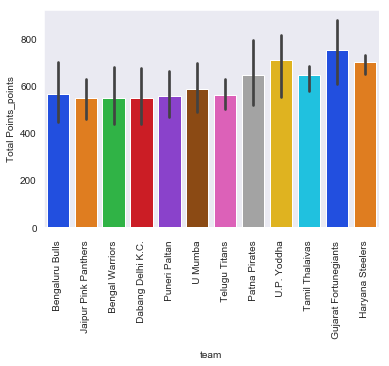

In [44]:
team_point = team_point.sort_values(by="Total Points_points")
sns.barplot(x="team",y="Total Points_points",data=team_point,palette="bright")
plt.xticks(rotation=90)

#### Points scored/ average points for team for season 7

In [45]:
team_point[["team","Played","Total Points_points","Avg Points Scored_points"]]

,team,Played,Total Points_points,Avg Points Scored_points
25,Bengaluru Bulls,14.0,360.0,23.21
17,Bengaluru Bulls,14.0,362.0,22.07
19,Jaipur Pink Panthers,14.0,364.0,22.14
8,Bengal Warriors,14.0,367.0,22.85
24,Bengal Warriors,14.0,378.0,23.35
18,Dabang Delhi K.C.,14.0,384.0,24.57
13,Puneri Paltan,14.0,391.0,24.07
10,Dabang Delhi K.C.,14.0,396.0,25.21
31,U Mumba,14.0,399.0,24.85
5,Puneri Paltan,14.0,405.0,26.85


#### Average points scored by team across seasons (1 thru 7)

In [46]:
team_c.loc[team_c["table"]=="Team - Avg Points Scored"].groupby("team").describe()

played                                         \
                            count       mean       std   min   25%   50%   
team                                                                       
   Bengal Warriors            7.0  17.857143  4.413184  14.0  14.0  16.0   
   Bengaluru Bulls            7.0  17.857143  3.933979  14.0  15.0  16.0   
   Dabang Delhi K.C.          7.0  17.428571  4.429339  14.0  14.0  14.0   
   Gujarat Fortunegiants      3.0  23.000000  2.645751  20.0  22.0  24.0   
   Haryana Steelers           3.0  21.333333  2.081666  19.0  20.5  22.0   
   Jaipur Pink Panthers       7.0  17.714286  3.545621  14.0  15.0  16.0   
   Patna Pirates              7.0  18.714286  3.946065  16.0  16.0  16.0   
   Puneri Paltan              7.0  18.000000  4.000000  14.0  15.0  16.0   
   Tamil Thalaivas            3.0  21.333333  1.154701  20.0  21.0  22.0   
   Telugu Titans              7.0  17.428571  3.408672  14.0  15.0  16.0   
   U Mumba                    7.0  18.000000  3.415650  14.0  16.0  16.0   
   U.P. Yoddha                3.0  22.000000  3.605551  18.0  20.5  23.0   

                                       points                              \
                             75%   max  count       mean       std    min   
team                                                                        
   Bengal Warriors          21.5  24.0    7.0  26.524286  2.951829  22.85   
   Bengaluru Bulls          20.5  24.0    7.0  27.100000  3.746736  22.07   
   Dabang Delhi K.C.        21.0  24.0    7.0  27.005714  3.029020  23.31   
   Gujarat Fortunegiants    24.5  25.0    3.0  27.920000  2.045898  26.15   
   Haryana Steelers         22.5  23.0    3.0  28.873333  1.348122  27.43   
   Jaipur Pink Panthers     21.0  22.0    7.0  26.711429  3.351007  22.14   
   Patna Pirates            20.5  26.0    7.0  29.601429  3.223199  24.50   
   Puneri Paltan            21.0  24.0    7.0  26.828571  1.663324  24.07   
   Tamil Thalaivas          22.0  22.0    3.0  27.050000  1.128007  25.75   
   Telugu Titans            20.0  22.0    7.0  28.524286  2.383791  26.42   
   U Mumba                  20.5  23.0    7.0  28.178571  2.816070  24.85   
   U.P. Yoddha              24.0  25.0    3.0  28.020000  1.131194  26.72   

                                                          
                               25%    50%     75%    max  
team                                                      
   Bengal Warriors          24.175  27.00  28.285  30.90  
   Bengaluru Bulls          24.605  26.95  29.550  32.37  
   Dabang Delhi K.C.        24.890  25.71  29.520  31.20  
   Gujarat Fortunegiants    26.800  27.45  28.805  30.16  
   Haryana Steelers         28.260  29.09  29.595  30.10  
   Jaipur Pink Panthers     24.560  26.71  28.445  32.12  
   Patna Pirates            27.900  29.42  31.650  34.19  
   Puneri Paltan            26.265  27.08  27.310  29.50  
   Tamil Thalaivas          26.690  27.63  27.700  27.77  
   Telugu Titans            26.720  27.59  29.985  32.25  
   U Mumba                  26.550  27.06  29.860  32.52  
   U.P. Yoddha              27.640  28.56  28.670  28.78

#### Conclusion -``` Top team in the points table - "Bengal Warriors"```

## Task 3: Predict the team with the highest points for successful raids.

#### Plot successful points for season 7

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

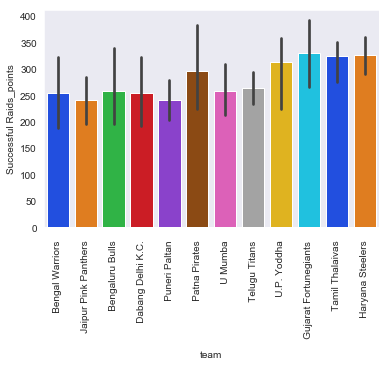

In [47]:
team_point = team_point.sort_values(by="Successful Raids_points")
sns.barplot(x="team",y="Successful Raids_points",data=team_point,palette="bright")
plt.xticks(rotation=90)

#### Successful raid points for team for season 7

In [48]:
team_point[["team","Total Points_points","Successful Raids_points"]]

,team,Total Points_points,Successful Raids_points
8,Bengal Warriors,367.0,134.0
19,Jaipur Pink Panthers,364.0,149.0
25,Bengaluru Bulls,360.0,157.0
17,Bengaluru Bulls,362.0,158.0
10,Dabang Delhi K.C.,396.0,159.0
26,Dabang Delhi K.C.,419.0,162.0
24,Bengal Warriors,378.0,167.0
13,Puneri Paltan,391.0,170.0
18,Dabang Delhi K.C.,384.0,171.0
12,Patna Pirates,444.0,182.0


#### Average raid points scored by team across seasons (1 thru 7)

In [49]:
team_c.loc[team_c["table"]=="Team - Average Raid Points"].groupby("team").describe()

played                                         \
                            count       mean       std   min   25%   50%   
team                                                                       
   Bengal Warriors            7.0  17.857143  4.413184  14.0  14.0  16.0   
   Bengaluru Bulls            7.0  17.857143  3.933979  14.0  15.0  16.0   
   Dabang Delhi K.C.          7.0  17.428571  4.429339  14.0  14.0  14.0   
   Gujarat Fortunegiants      3.0  23.000000  2.645751  20.0  22.0  24.0   
   Haryana Steelers           3.0  21.333333  2.081666  19.0  20.5  22.0   
   Jaipur Pink Panthers       7.0  17.714286  3.545621  14.0  15.0  16.0   
   Patna Pirates              7.0  18.714286  3.946065  16.0  16.0  16.0   
   Puneri Paltan              7.0  18.000000  4.000000  14.0  15.0  16.0   
   Tamil Thalaivas            3.0  21.333333  1.154701  20.0  21.0  22.0   
   Telugu Titans              7.0  17.428571  3.408672  14.0  15.0  16.0   
   U Mumba                    7.0  18.000000  3.415650  14.0  16.0  16.0   
   U.P. Yoddha                3.0  22.000000  3.605551  18.0  20.5  23.0   

                                       points                              \
                             75%   max  count       mean       std    min   
team                                                                        
   Bengal Warriors          21.5  24.0    7.0  17.518571  3.108491  13.14   
   Bengaluru Bulls          20.5  24.0    7.0  17.794286  3.099004  14.36   
   Dabang Delhi K.C.        21.0  24.0    7.0  18.037143  2.647267  15.50   
   Gujarat Fortunegiants    24.5  25.0    3.0  17.360000  1.653118  16.00   
   Haryana Steelers         22.5  23.0    3.0  19.243333  1.468888  17.57   
   Jaipur Pink Panthers     21.0  22.0    7.0  17.214286  2.408892  13.79   
   Patna Pirates            20.5  26.0    7.0  19.595714  3.450671  14.25   
   Puneri Paltan            21.0  24.0    7.0  16.911429  1.463676  15.69   
   Tamil Thalaivas          22.0  22.0    3.0  18.296667  0.971614  17.20   
   Telugu Titans            20.0  22.0    7.0  19.000000  2.799232  16.05   
   U Mumba                  20.5  23.0    7.0  17.805714  2.492133  14.81   
   U.P. Yoddha              24.0  25.0    3.0  18.020000  1.990678  16.06   

                                                          
                               25%    50%     75%    max  
team                                                      
   Bengal Warriors          15.030  18.96  19.585  21.30  
   Bengaluru Bulls          15.340  17.86  19.435  22.79  
   Dabang Delhi K.C.        15.890  16.64  20.245  21.85  
   Gujarat Fortunegiants    16.440  16.88  18.040  19.20  
   Haryana Steelers         18.705  19.84  20.080  20.32  
   Jaipur Pink Panthers     16.310  16.85  17.870  21.50  
   Patna Pirates            17.935  19.75  21.400  24.50  
   Puneri Paltan            15.760  15.93  18.015  19.21  
   Tamil Thalaivas          17.920  18.64  18.845  19.05  
   Telugu Titans            17.415  18.18  19.970  24.00  
   U Mumba                  16.010  17.11  19.505  21.69  
   U.P. Yoddha              17.010  17.96  19.000  20.04

#### Conclusion -``` Highest points for successful raids - "Bengal Warriors"```

## Task 4: Predict the team with the highest points for successful tackles. 

#### Plot successful tackles points for season 7

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

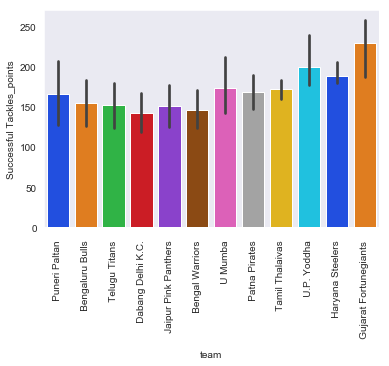

In [50]:
team_point = team_point.sort_values(by="Successful Tackles_points")
sns.barplot(x="team",y="Successful Tackles_points",data=team_point,palette="bright")
plt.xticks(rotation=90)

#### Successful tackle points for team for season 7

In [51]:
team_point[["team","Total Points_points","Successful Tackles_points"]]

,team,Total Points_points,Successful Tackles_points
5,Puneri Paltan,405.0,93.0
17,Bengaluru Bulls,362.0,94.0
6,Telugu Titans,497.0,96.0
18,Dabang Delhi K.C.,384.0,98.0
19,Jaipur Pink Panthers,364.0,101.0
22,Telugu Titans,427.0,101.0
13,Puneri Paltan,391.0,104.0
0,Bengal Warriors,430.0,106.0
25,Bengaluru Bulls,360.0,109.0
31,U Mumba,399.0,110.0


#### Average tackle points scored by team across seasons (1 thru 7)

In [52]:
team_c.loc[team_c["table"]=="Team - Average Tackle Points"].groupby("team").describe()

played                                         \
                            count       mean       std   min   25%   50%   
team                                                                       
   Bengal Warriors            7.0  17.857143  4.413184  14.0  14.0  16.0   
   Bengaluru Bulls            7.0  17.857143  3.933979  14.0  15.0  16.0   
   Dabang Delhi K.C.          7.0  17.428571  4.429339  14.0  14.0  14.0   
   Gujarat Fortunegiants      3.0  23.000000  2.645751  20.0  22.0  24.0   
   Haryana Steelers           3.0  21.333333  2.081666  19.0  20.5  22.0   
   Jaipur Pink Panthers       7.0  17.714286  3.545621  14.0  15.0  16.0   
   Patna Pirates              7.0  18.714286  3.946065  16.0  16.0  16.0   
   Puneri Paltan              7.0  18.000000  4.000000  14.0  15.0  16.0   
   Tamil Thalaivas            3.0  21.333333  1.154701  20.0  21.0  22.0   
   Telugu Titans              7.0  17.428571  3.408672  14.0  15.0  16.0   
   U Mumba                    7.0  18.000000  3.415650  14.0  16.0  16.0   
   U.P. Yoddha                3.0  22.000000  3.605551  18.0  20.5  23.0   

                                       points                              \
                             75%   max  count       mean       std    min   
team                                                                        
   Bengal Warriors          21.5  24.0    7.0   9.010000  0.592790   8.04   
   Bengaluru Bulls          20.5  24.0    7.0   9.308571  1.098354   7.14   
   Dabang Delhi K.C.        21.0  24.0    7.0   8.972857  0.832521   7.68   
   Gujarat Fortunegiants    24.5  25.0    3.0  10.563333  0.405257  10.15   
   Haryana Steelers         22.5  23.0    3.0   9.633333  0.772679   8.77   
   Jaipur Pink Panthers     21.0  22.0    7.0   9.502857  1.273966   7.77   
   Patna Pirates            20.5  26.0    7.0  10.011429  0.869357   8.88   
   Puneri Paltan            21.0  24.0    7.0   9.920000  1.674515   7.64   
   Tamil Thalaivas          22.0  22.0    3.0   8.760000  0.329697   8.55   
   Telugu Titans            20.0  22.0    7.0   9.530000  1.243007   7.43   
   U Mumba                  20.5  23.0    7.0  10.377143  1.509986   8.64   
   U.P. Yoddha              24.0  25.0    3.0  10.003333  1.094638   8.74   

                                                          
                               25%    50%     75%    max  
team                                                      
   Bengal Warriors           8.705   8.93   9.490   9.71  
   Bengaluru Bulls           8.975   9.58  10.120  10.25  
   Dabang Delhi K.C.         8.465   9.35   9.570   9.71  
   Gujarat Fortunegiants    10.365  10.58  10.770  10.96  
   Haryana Steelers          9.320   9.87  10.065  10.26  
   Jaipur Pink Panthers      8.400  10.14  10.430  10.95  
   Patna Pirates             9.415  10.05  10.470  11.38  
   Puneri Paltan             8.635   9.95  11.445  11.69  
   Tamil Thalaivas           8.570   8.59   8.865   9.14  
   Telugu Titans             8.850  10.11  10.360  10.75  
   U Mumba                   9.405   9.81  11.405  12.57  
   U.P. Yoddha               9.670  10.60  10.635  10.67

#### Conclusion -``` Highest points for successful tackles  - "Puneri Paltan"```

## Task 5: Predict the team with the highest super-performance total.

#### Plot Super-Performance points for season 7

In [53]:
team_point.columns

Index(['team', 'Played', 'Successful Raids_points',
       'Successful Tackles_points', 'Super Tackles_points',
       'Tackle Points_points', 'Total Points_points', 'Raid Points_points',
       'Average Raid Points_points', 'Average Tackle Points_points',
       'Total Points Conceded_points', 'Super Raid_points',
       'DOD Raid Points_points', 'All-outs Inflicted_points',
       'All-outs Conceded_points', 'Avg Points Scored_points', 'season'],
      dtype='object')

In [54]:
# Derived field
team_point["SPT"] = team_point["Successful Raids_points"] + team_point["Super Tackles_points"] + team_point["All-outs Inflicted_points"] - team_point["All-outs Conceded_points"]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

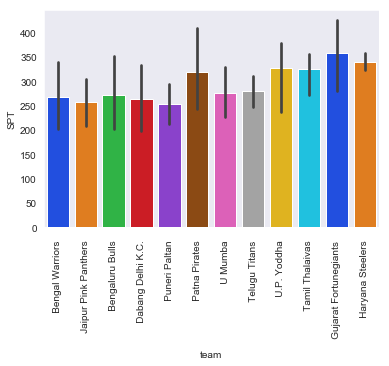

In [55]:
team_point = team_point.sort_values(by="SPT")
sns.barplot(x="team",y="SPT",data=team_point,palette="bright")
plt.xticks(rotation=90)

#### Super Performance points for team for season 7

In [56]:
team_point[["team","Total Points_points","SPT"]]

,team,Total Points_points,SPT
8,Bengal Warriors,367.0,147.0
19,Jaipur Pink Panthers,364.0,154.0
17,Bengaluru Bulls,362.0,155.0
25,Bengaluru Bulls,360.0,160.0
18,Dabang Delhi K.C.,384.0,165.0
10,Dabang Delhi K.C.,396.0,166.0
24,Bengal Warriors,378.0,171.0
13,Puneri Paltan,391.0,171.0
26,Dabang Delhi K.C.,419.0,179.0
12,Patna Pirates,444.0,186.0


#### Conclusion -``` Highest points for Super Performance - "Bengal Warriors"```

## Task 6: Predict the player with the highest SUCCESSFUL RAID percentage. 

In [57]:
cri_list

array(['Player - Successful Raids', 'Player - Raid Points',
       'Player - Successful Tackles', 'Player - Super Tackles',
       'Player - Super 10s', 'Player - High 5s', 'Player - Total Points',
       'Player - Tackle Points', 'Player - Super Raids',
       'Player - DOD Raid Points', 'Player - Avg Raid Points',
       'Player - Avg Tackle Points'], dtype=object)

In [58]:
task_6_1 = player_all.loc[(player_all["table"]=="Player - Successful Raids") & (player_all["season"]=="7")]
task_6_1.rename(columns = {"points": "successful_raids"}, inplace = True)

C:\Users\rush2\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [59]:
task_6_2 = player_all.loc[(player_all["table"]=="Player - Raid Points") & (player_all["season"]=="7")]
task_6_2.rename(columns = {"points": "raid_points"}, inplace = True)

In [60]:
task_6_3 = pd.merge(task_6_1,task_6_2,how='inner',on='player')
task_6_3.head()

,played_x,player,successful_raids,season_x,table_x,played_y,raid_points,season_y,table_y
0,20.0,Naveen Kumar,213.0,7,Player - Successful Raids,20.0,256.0,7,Player - Raid Points
1,19.0,Pardeep Narwal,190.0,7,Player - Successful Raids,19.0,243.0,7,Player - Raid Points
2,19.0,Pawan Sehrawat,187.0,7,Player - Successful Raids,19.0,242.0,7,Player - Raid Points
3,20.0,Maninder Singh,171.0,7,Player - Successful Raids,20.0,205.0,7,Player - Raid Points
4,18.0,Siddharth Desai,143.0,7,Player - Successful Raids,18.0,174.0,7,Player - Raid Points


In [61]:
task_6_3['successful_raid_%'] = round((task_6_3['successful_raids'] / task_6_3['raid_points'])*100,2)
task_6_3.head()

,played_x,player,successful_raids,season_x,table_x,played_y,raid_points,season_y,table_y,successful_raid_%
0,20.0,Naveen Kumar,213.0,7,Player - Successful Raids,20.0,256.0,7,Player - Raid Points,83.20
1,19.0,Pardeep Narwal,190.0,7,Player - Successful Raids,19.0,243.0,7,Player - Raid Points,78.19
2,19.0,Pawan Sehrawat,187.0,7,Player - Successful Raids,19.0,242.0,7,Player - Raid Points,77.27
3,20.0,Maninder Singh,171.0,7,Player - Successful Raids,20.0,205.0,7,Player - Raid Points,83.41
4,18.0,Siddharth Desai,143.0,7,Player - Successful Raids,18.0,174.0,7,Player - Raid Points,82.18


In [62]:
# Removing anomalous data
task_6_4 = task_6_3[task_6_3['successful_raid_%'] < 99.99]
task_6_4.sort_values(by='successful_raid_%',ascending=True)

,played_x,player,successful_raids,season_x,table_x,played_y,raid_points,season_y,table_y,successful_raid_%
78,19.0,Surender Singh,1.0,7,Player - Successful Raids,4.0,10.0,7,Player - Raid Points,10.00
63,9.0,Amit Kumar,2.0,7,Player - Successful Raids,13.0,17.0,7,Player - Raid Points,11.76
64,9.0,Amit Kumar,2.0,7,Player - Successful Raids,6.0,16.0,7,Player - Raid Points,12.50
59,3.0,Amit Kumar,3.0,7,Player - Successful Raids,13.0,17.0,7,Player - Raid Points,17.65
60,3.0,Amit Kumar,3.0,7,Player - Successful Raids,6.0,16.0,7,Player - Raid Points,18.75
79,19.0,Surender Singh,1.0,7,Player - Successful Raids,19.0,4.0,7,Player - Raid Points,25.00
109,17.0,Dharmaraj Cheralathan,1.0,7,Player - Successful Raids,17.0,3.0,7,Player - Raid Points,33.33
90,11.0,Vineet Sharma,3.0,7,Player - Successful Raids,11.0,9.0,7,Player - Raid Points,33.33
65,9.0,Amit Kumar,2.0,7,Player - Successful Raids,3.0,5.0,7,Player - Raid Points,40.00
118,2.0,Balram,1.0,7,Player - Successful Raids,2.0,2.0,7,Player - Raid Points,50.00


<Figure size 17100x6750 with 0 Axes>

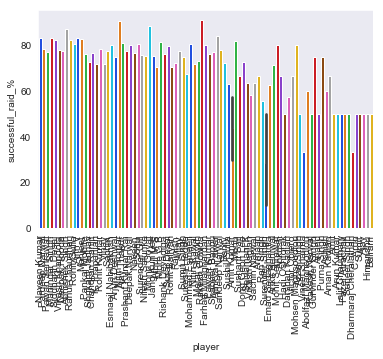

<Figure size 17100x6750 with 0 Axes>

In [63]:
sns.barplot(x="player",y="successful_raid_%",data=task_6_4,palette="bright")
plt.xticks(rotation=90)
plt.figure(num=None,figsize=(190,75),dpi=90)

### Conclusion: Rakesh Gowda has the highest successful raid percentage i.e. 90.91%

## Task 7: Predict the player with the highest SUCCESSFUL TACKLE percentage.

In [64]:
task_7_1 = player_all.loc[(player_all["table"]=="Player - Successful Tackles") & (player_all["season"]=="7")]
task_7_1.rename(columns = {"points": "successful_tackles"}, inplace = True)
task_7_1.head()

C:\Users\rush2\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,played,player,successful_tackles,season,table
0,20.0,Sandeep Dhull,60.0,7,Player - Successful Tackles
1,18.0,Sumit,60.0,7,Player - Successful Tackles
2,20.0,Ravinder Pahal,57.0,7,Player - Successful Tackles
3,19.0,Fazel Atrachali,57.0,7,Player - Successful Tackles
4,20.0,Baldev Singh,54.0,7,Player - Successful Tackles


In [65]:
task_7_2 = player_all.loc[(player_all["table"]=="Player - Tackle Points") & (player_all["season"]=="7")]
task_7_2.rename(columns = {"points": "Tackle_points"}, inplace = True)
task_7_2.head()

,played,player,Tackle_points,season,table
0,20.0,Sandeep Dhull,67.0,7,Player - Tackle Points
1,18.0,Vishal Bharadwaj,61.0,7,Player - Tackle Points
2,18.0,Sumit,61.0,7,Player - Tackle Points
3,19.0,Fazel Atrachali,60.0,7,Player - Tackle Points
4,20.0,Baldev Singh,59.0,7,Player - Tackle Points


In [66]:
task_7_3 = pd.merge(task_7_1,task_7_2,how='inner',on='player')
task_7_3.head()

,played_x,player,successful_tackles,season_x,table_x,played_y,Tackle_points,season_y,table_y
0,20.0,Sandeep Dhull,60.0,7,Player - Successful Tackles,20.0,67.0,7,Player - Tackle Points
1,18.0,Sumit,60.0,7,Player - Successful Tackles,18.0,61.0,7,Player - Tackle Points
2,18.0,Sumit,60.0,7,Player - Successful Tackles,2.0,1.0,7,Player - Tackle Points
3,2.0,Sumit,1.0,7,Player - Successful Tackles,18.0,61.0,7,Player - Tackle Points
4,2.0,Sumit,1.0,7,Player - Successful Tackles,2.0,1.0,7,Player - Tackle Points


In [67]:
task_7_3['successful_tackle_%'] = round((task_7_3['successful_tackles'] / task_7_3['Tackle_points'])*100,2)
task_7_3.head()

,played_x,player,successful_tackles,season_x,table_x,played_y,Tackle_points,season_y,table_y,successful_tackle_%
0,20.0,Sandeep Dhull,60.0,7,Player - Successful Tackles,20.0,67.0,7,Player - Tackle Points,89.55
1,18.0,Sumit,60.0,7,Player - Successful Tackles,18.0,61.0,7,Player - Tackle Points,98.36
2,18.0,Sumit,60.0,7,Player - Successful Tackles,2.0,1.0,7,Player - Tackle Points,6000.00
3,2.0,Sumit,1.0,7,Player - Successful Tackles,18.0,61.0,7,Player - Tackle Points,1.64
4,2.0,Sumit,1.0,7,Player - Successful Tackles,2.0,1.0,7,Player - Tackle Points,100.00


In [68]:
# Removing anomalous data
task_7_4 = task_7_3[task_7_3['successful_tackle_%'] < 99.99]
task_7_4.sort_values(by='successful_tackle_%',ascending=True)

,played_x,player,successful_tackles,season_x,table_x,played_y,Tackle_points,season_y,table_y,successful_tackle_%
3,2.0,Sumit,1.0,7,Player - Successful Tackles,18.0,61.0,7,Player - Tackle Points,1.64
18,4.0,Surender Singh,1.0,7,Player - Successful Tackles,19.0,45.0,7,Player - Tackle Points,2.22
57,6.0,Amit Kumar,1.0,7,Player - Successful Tackles,13.0,20.0,7,Player - Tackle Points,5.00
48,5.0,Amit,2.0,7,Player - Successful Tackles,18.0,23.0,7,Player - Tackle Points,8.70
58,6.0,Amit Kumar,1.0,7,Player - Successful Tackles,9.0,10.0,7,Player - Tackle Points,10.00
76,7.0,Ankit,5.0,7,Player - Successful Tackles,12.0,13.0,7,Player - Tackle Points,38.46
54,9.0,Amit Kumar,8.0,7,Player - Successful Tackles,13.0,20.0,7,Player - Tackle Points,40.00
59,6.0,Amit Kumar,1.0,7,Player - Successful Tackles,6.0,2.0,7,Player - Tackle Points,50.00
147,1.0,Mohit Balyan,1.0,7,Player - Successful Tackles,1.0,2.0,7,Player - Tackle Points,50.00
150,3.0,Victor Obiero,1.0,7,Player - Successful Tackles,3.0,2.0,7,Player - Tackle Points,50.00


<Figure size 17100x6750 with 0 Axes>

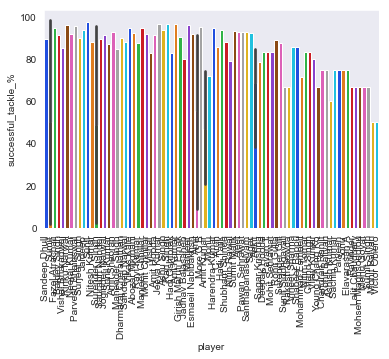

<Figure size 17100x6750 with 0 Axes>

In [69]:
sns.barplot(x="player",y="successful_tackle_%",data=task_7_4,palette="bright")
plt.xticks(rotation=90)
plt.figure(num=None,figsize=(190,75),dpi=90)

### Conclusion : Sumit has the highest successful tackle percetage i.e. 98.36

## Model Bulding

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# df_train, df_test = train_test_split(team_point, train_size = 0.7, test_size = 0.3, random_state = 100)

In [141]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

## Model - 1

Let's trian model on season 1 thru 6

In [142]:
train_df = team_point.loc[team_point["season"]!="7"]
train_df.head()

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Tackle Points_points,Total Points_points,Raid Points_points,Average Raid Points_points,Average Tackle Points_points,Total Points Conceded_points,Super Raid_points,DOD Raid Points_points,All-outs Inflicted_points,All-outs Conceded_points,Avg Points Scored_points,season,SPT
8,Bengal Warriors,14.0,134.0,116.0,20.0,136.0,367.0,184.0,13.14,9.71,430.0,9.0,59.0,10.0,17.0,22.85,2,147.0
19,Jaipur Pink Panthers,14.0,149.0,101.0,16.0,117.0,364.0,193.0,13.79,8.36,427.0,8.0,59.0,11.0,22.0,22.14,3,154.0
17,Bengaluru Bulls,14.0,158.0,94.0,6.0,100.0,362.0,209.0,14.93,7.14,467.0,9.0,69.0,12.0,21.0,22.07,3,155.0
25,Bengaluru Bulls,14.0,157.0,109.0,15.0,124.0,360.0,201.0,14.36,8.86,415.0,4.0,59.0,9.0,21.0,23.21,4,160.0
18,Dabang Delhi K.C.,14.0,171.0,98.0,13.0,111.0,384.0,233.0,16.64,7.93,525.0,5.0,54.0,9.0,28.0,24.57,3,165.0


In [143]:
test_df = team_point.loc[team_point["season"]=="7"]
test_df.head()

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Tackle Points_points,Total Points_points,Raid Points_points,Average Raid Points_points,Average Tackle Points_points,Total Points Conceded_points,Super Raid_points,DOD Raid Points_points,All-outs Inflicted_points,All-outs Conceded_points,Avg Points Scored_points,season,SPT
67,U.P. Yoddha,18.0,223.0,177.0,16.0,192.0,551.0,289.0,16.06,10.67,570.0,5.0,71.0,21.0,22.0,26.72,7,238.0
64,Tamil Thalaivas,20.0,275.0,160.0,13.0,171.0,578.0,344.0,17.20,8.55,695.0,4.0,55.0,14.0,30.0,25.75,7,272.0
66,U Mumba,19.0,258.0,168.0,18.0,183.0,598.0,325.0,17.11,9.63,561.0,7.0,66.0,26.0,21.0,26.73,7,281.0
59,Gujarat Fortunegiants,20.0,265.0,187.0,17.0,203.0,605.0,320.0,16.00,10.15,591.0,5.0,59.0,21.0,22.0,26.15,7,281.0
65,Telugu Titans,18.0,273.0,162.0,21.0,182.0,564.0,332.0,18.44,10.11,603.0,9.0,44.0,13.0,22.0,28.55,7,285.0


Create X and y

In [144]:
# Check datatype of columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 8 to 38
Data columns (total 18 columns):
team                            56 non-null object
Played                          56 non-null float64
Successful Raids_points         56 non-null float64
Successful Tackles_points       56 non-null float64
Super Tackles_points            56 non-null float64
Tackle Points_points            56 non-null float64
Total Points_points             56 non-null float64
Raid Points_points              56 non-null float64
Average Raid Points_points      56 non-null float64
Average Tackle Points_points    56 non-null float64
Total Points Conceded_points    56 non-null float64
Super Raid_points               56 non-null float64
DOD Raid Points_points          56 non-null float64
All-outs Inflicted_points       56 non-null float64
All-outs Conceded_points        56 non-null float64
Avg Points Scored_points        56 non-null float64
season                          56 non-null object
SPT            

In [145]:
# Convert season to int
train_df["season"] = train_df["season"].astype("int")
train_df.info()
test_df["season"] = test_df["season"].astype("int")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 8 to 38
Data columns (total 18 columns):
team                            56 non-null object
Played                          56 non-null float64
Successful Raids_points         56 non-null float64
Successful Tackles_points       56 non-null float64
Super Tackles_points            56 non-null float64
Tackle Points_points            56 non-null float64
Total Points_points             56 non-null float64
Raid Points_points              56 non-null float64
Average Raid Points_points      56 non-null float64
Average Tackle Points_points    56 non-null float64
Total Points Conceded_points    56 non-null float64
Super Raid_points               56 non-null float64
DOD Raid Points_points          56 non-null float64
All-outs Inflicted_points       56 non-null float64
All-outs Conceded_points        56 non-null float64
Avg Points Scored_points        56 non-null float64
season                          56 non-null int32
SPT             

In [146]:
# Lavel encoding for team
team_map = {'   Bengal Warriors  ':0, '   Jaipur Pink Panthers  ':1,
       '   Bengaluru Bulls  ':2, '   Dabang Delhi K.C.  ':3,
       '   Puneri Paltan  ':4, '   Patna Pirates  ':5, '   U Mumba  ':6,
       '   Telugu Titans  ':7, '   Tamil Thalaivas  ':8,
       '   Haryana Steelers  ':9, '   Gujarat Fortunegiants  ':10,
       '   U.P. Yoddha  ':11}
train_df["team"] = train_df["team"].map(team_map)
train_df.head()

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Tackle Points_points,Total Points_points,Raid Points_points,Average Raid Points_points,Average Tackle Points_points,Total Points Conceded_points,Super Raid_points,DOD Raid Points_points,All-outs Inflicted_points,All-outs Conceded_points,Avg Points Scored_points,season,SPT
8,0,14.0,134.0,116.0,20.0,136.0,367.0,184.0,13.14,9.71,430.0,9.0,59.0,10.0,17.0,22.85,2,147.0
19,1,14.0,149.0,101.0,16.0,117.0,364.0,193.0,13.79,8.36,427.0,8.0,59.0,11.0,22.0,22.14,3,154.0
17,2,14.0,158.0,94.0,6.0,100.0,362.0,209.0,14.93,7.14,467.0,9.0,69.0,12.0,21.0,22.07,3,155.0
25,2,14.0,157.0,109.0,15.0,124.0,360.0,201.0,14.36,8.86,415.0,4.0,59.0,9.0,21.0,23.21,4,160.0
18,3,14.0,171.0,98.0,13.0,111.0,384.0,233.0,16.64,7.93,525.0,5.0,54.0,9.0,28.0,24.57,3,165.0


#### Scaling variables

In [147]:
y_train = train_df.pop("Total Points_points")
X_train = train_df

In [114]:
# # Adding feature variables to x and y
# x = team_point[['Played', 'Successful Raids_points','Successful Tackles_points','Raid Points_points','Average Raid Points_points', 'Average Tackle Points_points','Total Points Conceded_points', 'Super Raid_points','All-outs Inflicted_points',
#        'All-outs Conceded_points', 'Avg Points Scored_points']]
# y = team_point['Total Points_points']

In [149]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)
lm_1 = sm.OLS(y_train,X_train_sm).fit()
print(lm_1.summary())

                             OLS Regression Results                            
Dep. Variable:     Total Points_points   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                     1530.
Date:                 Wed, 02 Oct 2019   Prob (F-statistic):           2.04e-49
Time:                         09:48:21   Log-Likelihood:                -185.17
No. Observations:                   56   AIC:                             404.3
Df Residuals:                       39   BIC:                             438.8
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

In [150]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,SPT,inf
2,Successful Raids_points,inf
4,Super Tackles_points,inf
13,All-outs Conceded_points,inf
12,All-outs Inflicted_points,inf
14,Avg Points Scored_points,45159916.89
7,Average Raid Points_points,19426769.40
8,Average Tackle Points_points,5478805.09
5,Tackle Points_points,140399.67
3,Successful Tackles_points,110777.22


## Model -2

In [169]:
cols = ['team', 'Played', 'Successful Raids_points',
       'Successful Tackles_points', 'Super Tackles_points',
       'Tackle Points_points', 'Raid Points_points',
       'Average Raid Points_points', 'Average Tackle Points_points',
       'Total Points Conceded_points', 'Super Raid_points',
       'DOD Raid Points_points', 'All-outs Inflicted_points',
       'All-outs Conceded_points', 'Avg Points Scored_points', 'season']

In [170]:
X_train = train_df[cols]
X_train.head()

,team,Played,Successful Raids_points,Successful Tackles_points,Super Tackles_points,Tackle Points_points,Raid Points_points,Average Raid Points_points,Average Tackle Points_points,Total Points Conceded_points,Super Raid_points,DOD Raid Points_points,All-outs Inflicted_points,All-outs Conceded_points,Avg Points Scored_points,season
8,0,14.0,134.0,116.0,20.0,136.0,184.0,13.14,9.71,430.0,9.0,59.0,10.0,17.0,22.85,2
19,1,14.0,149.0,101.0,16.0,117.0,193.0,13.79,8.36,427.0,8.0,59.0,11.0,22.0,22.14,3
17,2,14.0,158.0,94.0,6.0,100.0,209.0,14.93,7.14,467.0,9.0,69.0,12.0,21.0,22.07,3
25,2,14.0,157.0,109.0,15.0,124.0,201.0,14.36,8.86,415.0,4.0,59.0,9.0,21.0,23.21,4
18,3,14.0,171.0,98.0,13.0,111.0,233.0,16.64,7.93,525.0,5.0,54.0,9.0,28.0,24.57,3


In [171]:
X_train_sm = sm.add_constant(X_train)
lm_2 = sm.OLS(y_train,X_train_sm).fit()
print(lm_1.summary())

                             OLS Regression Results                            
Dep. Variable:     Total Points_points   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                     1530.
Date:                 Wed, 02 Oct 2019   Prob (F-statistic):           2.04e-49
Time:                         09:52:02   Log-Likelihood:                -185.17
No. Observations:                   56   AIC:                             404.3
Df Residuals:                       39   BIC:                             438.8
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

In [172]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
14,Avg Points Scored_points,45159916.89
7,Average Raid Points_points,19426769.40
8,Average Tackle Points_points,5478805.09
5,Tackle Points_points,140399.67
3,Successful Tackles_points,110777.22
6,Raid Points_points,3369.30
2,Successful Raids_points,2001.06
4,Super Tackles_points,1035.78
1,Played,914.17
9,Total Points Conceded_points,818.80


**This model looks stable as the p value is less than 0.05 and the prob(f-statistic) is almost 0.**

In [86]:
# Making predictions using the model
# x_pred = team_point[['Played','Raid Points_points','All-outs Inflicted_points']]
# x_pred = sm.add_constant(x_pred)
Predicted_views = lm_1.predict(x_pred)
Predicted_views

8      359.823746
19     370.120330
17     385.148244
25     367.100668
18     388.729600
10     394.768925
24     376.203468
13     394.610902
26     409.278957
12     436.215251
31     409.954862
5      425.702491
11     421.761278
15     471.792523
9      502.998324
0      430.951701
22     419.777377
30     500.496542
27     481.457015
16     467.938933
23     512.101123
21     502.322419
67     545.164366
28     485.828486
1      508.291345
29     511.828889
2      461.797644
20     572.730659
4      516.762053
64     586.856339
         ...     
37     660.658440
3      582.035293
63     613.172788
51     622.219529
60     646.930306
53     643.804648
62     645.060616
57     632.464085
42     701.054664
39     754.377806
41     705.066276
49     702.564495
52     696.841216
36     733.202479
40     686.544631
33     712.975291
44     737.977620
48     698.912740
35     788.805104
43     754.875223
56     726.549432
55     793.416098
58     733.984378
32     784.679280
54     829